<a href="https://colab.research.google.com/github/MoritzDaw/CaseStudy/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTERNAL – Solution Notebook (NOT for candidates)
This notebook contains a complete reference implementation for the AI Procurement Case Study.

Do NOT share with candidates.  
This is strictly for internal evaluation & validation.


In [1]:
!pip install pandas requests matplotlib seaborn scikit-learn --quiet
!pip install sentence-transformers --quiet


import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sentence_transformers import SentenceTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer



In [3]:
SUPABASE_URL = "https://vdpgndvedvnxrwtmvohk.supabase.co"
API_KEY = "sb_publishable_hc3knof84c84yXuTLdNYYA_88LwtPz-"

headers = {
    "apikey": API_KEY,
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json",
}


In [55]:
import math
import pandas as pd
import requests


def supabase_get_all(table: str, batch_size: int = 1000, query_params: str = "") -> pd.DataFrame:
    """
    Fetch all rows from a Supabase table using simple offset-based pagination.
    """
    all_rows = []
    offset = 0

    while True:
        base = f"{SUPABASE_URL}/rest/v1/{table}"
        qp = f"{query_params}&" if query_params else ""
        url = f"{base}?{qp}limit={batch_size}&offset={offset}"

        res = requests.get(url, headers=headers)
        if res.status_code != 200:
            raise Exception(f"Error fetching {table}: {res.status_code} - {res.text}")

        batch = res.json()
        if not batch:
            break

        all_rows.extend(batch)
        if len(batch) < batch_size:
            break

        offset += batch_size

    return pd.DataFrame(all_rows)


In [56]:
# Load core tables
df_lfa1 = supabase_get_all("lfa1")
df_ekko = supabase_get_all("ekko")
df_ekpo = supabase_get_all("ekpo")
df_po_events = supabase_get_all("po_events")

print("Shapes:")
print("LFA1:", df_lfa1.shape)
print("EKKO:", df_ekko.shape)
print("EKPO:", df_ekpo.shape)
print("PO_EVENTS:", df_po_events.shape)

# Quick preview
display(df_lfa1.head())
display(df_ekko.head())
display(df_ekpo.head())
display(df_po_events.head())

Shapes:
LFA1: (200, 4)
EKKO: (5000, 7)
EKPO: (15000, 7)
PO_EVENTS: (7407, 6)


,lifnr,name1,country,risk_score
0,100000,Delta Präzisionsteile GmbH,DE,2
1,100001,Iota Befestigungstechnik KG,DE,5
2,100002,Theta Werkzeugbau GmbH,DE,3
3,100003,Delta Präzisionsteile GmbH,CN,3
4,100004,Theta Tools,DE,1


,ebeln,lifnr,bukrs,bedat,bsart,release_indicator,header_text
0,4500000000,100094,CZ01,2024-10-09,NB,True,Bestellung für Blechteile für geplante Instandhaltung.
1,4500000001,100010,DE03,2024-07-05,NB,True,Nachbestellung von Serienteile für Kundenauftrag mit engem Liefertermin.
2,4500000002,100053,DE02,2024-12-07,NB,True,Nachbestellung von Dichtungen zur Stabilisierung der Lieferkette.
3,4500000003,100143,PL01,2024-11-13,NB,False,Langfristige Bestellung für Hydraulikkomponenten für laufende Serienproduktion. Lieferant hatte zuletzt wiederholt Verspätungen.
4,4500000004,100060,DE02,2025-02-13,NB,True,Eilbestellung für Hydraulikkomponenten nach Qualitätsproblemen im Vorlauf.


,ebeln,ebelp,matnr,menge,eindt,price,item_text
0,4500000000,10,M-691978,13.0,2024-10-21,35.25,Regellieferung für Sensorikkomponenten mit vereinbarten Lieferbedingungen.
1,4500000000,20,M-614531,24.0,2024-11-01,18.17,Regellieferung für Filterelementen für Serviceeinsätze beim Kunden.
2,4500000000,30,P-189919,62.0,2024-11-10,41.75,Eilversand für Hydraulikschläuchen für Linie 2.
3,4500000000,40,C-145730,10.0,2024-10-17,47.45,Planlieferung für Pumpenkomponenten für Linie 1.
4,4500000001,10,P-512130,11.0,2024-08-17,51.99,Nachlieferung von Pumpenkomponenten zur Lagerauffüllung.


,id,ebeln,event_ts,event_type,severity,comment
0,1,4500000000,2024-10-17T00:00:00,INVOICE_MATCHED,1,Communication via phone was slower than usual; additional information pending.
1,2,4500000000,2024-11-21T00:00:00,REMINDER_SENT,1,"Internal review at line A1 highlighted minor process gaps, awaiting supplier confirmation."
2,3,4500000000,2024-10-23T00:00:00,INVOICE_MATCHED,1,Inspection at IT03 noted minor deviations; delay absorbed by internal buffer.
3,4,4500000002,2025-01-02T00:00:00,REMINDER_SENT,1,"Supplier mentioned potential scheduling adjustments for seal kits, awaiting supplier confirmation."
4,5,4500000002,2025-01-19T00:00:00,LATE_DELIVERY,1,"Shipment of hydraulic hoses to NL02 reported delayed compared to original plan, risk cannot be fully ruled out."


In [57]:
# --- Type casting: run this once after loading ---

# LFA1
if "risk_score" in df_lfa1.columns:
    df_lfa1["risk_score"] = pd.to_numeric(df_lfa1["risk_score"], errors="coerce")

# EKKO
if "bedat" in df_ekko.columns:
    df_ekko["bedat"] = pd.to_datetime(df_ekko["bedat"], errors="coerce")

# EKPO
for col in ["menge", "price"]:
    if col in df_ekpo.columns:
        df_ekpo[col] = pd.to_numeric(df_ekpo[col], errors="coerce")

for col in ["eindt"]:
    if col in df_ekpo.columns:
        df_ekpo[col] = pd.to_datetime(df_ekpo[col], errors="coerce")

# PO_EVENTS
for col in ["severity"]:
    if col in df_po_events.columns:
        df_po_events[col] = pd.to_numeric(df_po_events[col], errors="coerce")

for col in ["event_ts"]:
    if col in df_po_events.columns:
        df_po_events[col] = pd.to_datetime(df_po_events[col], errors="coerce")


=== Missing Values (%) ===

LFA1


,0
lifnr,0.0
name1,0.0
country,0.0
risk_score,0.0



EKKO


,0
ebeln,0.0
lifnr,0.0
bukrs,0.0
bedat,0.0
bsart,0.0
release_indicator,0.0
header_text,0.0



EKPO


,0
ebeln,0.0
ebelp,0.0
matnr,0.0
menge,0.0
eindt,0.0
price,0.0
item_text,0.0



PO_EVENTS


,0
id,0.0
ebeln,0.0
event_ts,0.0
event_type,0.0
severity,0.0
comment,0.0



=== Data Types ===

LFA1


,0
lifnr,object
name1,object
country,object
risk_score,int64



EKKO


,0
ebeln,object
lifnr,object
bukrs,object
bedat,datetime64[ns]
bsart,object
release_indicator,bool
header_text,object



EKPO


,0
ebeln,object
ebelp,int64
matnr,object
menge,float64
eindt,datetime64[ns]
price,float64
item_text,object



PO_EVENTS


,0
id,int64
ebeln,object
event_ts,datetime64[ns]
event_type,object
severity,int64
comment,object



=== Duplicate Checks ===
LFA1: 0 duplicates
EKKO: 0 duplicates
EKPO: 0 duplicates
PO_EVENTS: 0 duplicates

=== Unique Key Checks ===
LFA1.lifnr unique: True
EKKO.ebeln unique: True
EKPO has duplicates on (ebeln, ebelp): 0

=== Referential Integrity ===
POs with missing suppliers: 0
Items without PO header: 0
Events without PO header: 0

=== Numerical Summary Statistics ===
EKKO: no numeric columns detected.
EKPO: numeric columns -> ['ebelp', 'menge', 'price']


,ebelp,menge,price
count,15000.000000,15000.000000,15000.000000
mean,26.655333,24.146533,38.030687
std,14.849284,15.913737,30.355328
min,10.000000,2.000000,2.270000
25%,10.000000,13.000000,18.700000
50%,20.000000,20.000000,29.940000
75%,40.000000,30.000000,47.530000
max,60.000000,184.000000,689.080000


LFA1: numeric columns -> ['risk_score']


,risk_score
count,200.000000
mean,2.425000
std,1.237754
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,5.000000


PO_EVENTS: numeric columns -> ['id', 'severity']


,id,severity
count,7407.000000,7407.000000
mean,3704.000000,1.509113
std,2138.361055,1.054493
min,1.000000,1.000000
25%,1852.500000,1.000000
50%,3704.000000,1.000000
75%,5555.500000,1.000000
max,7407.000000,5.000000



=== Supplier Country Distribution ===


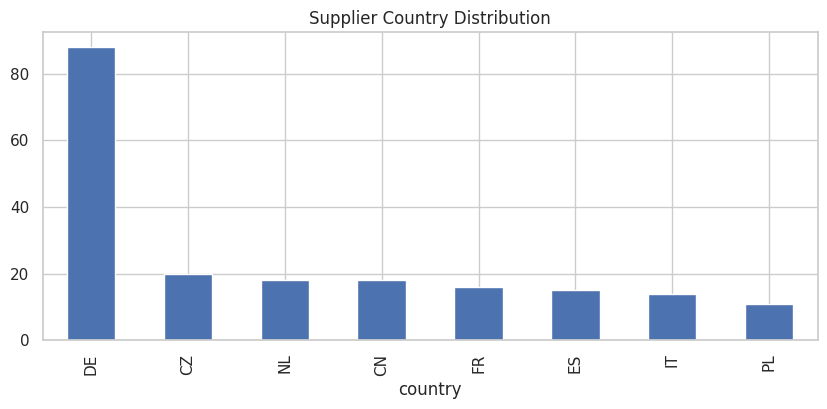


=== Supplier Risk (aggregated from PO_EVENTS) ===


,lifnr,event_count,avg_severity,max_severity
88,100088,27,2.370370,5
34,100034,20,2.350000,5
127,100127,39,2.256410,5
60,100060,33,2.212121,5
65,100065,25,2.160000,5
1,100001,27,2.148148,5
140,100140,35,2.085714,5
114,100114,20,2.050000,5
196,100196,61,2.049180,5
122,100122,25,2.040000,4



=== PO Count by Document Type (bsart) ===


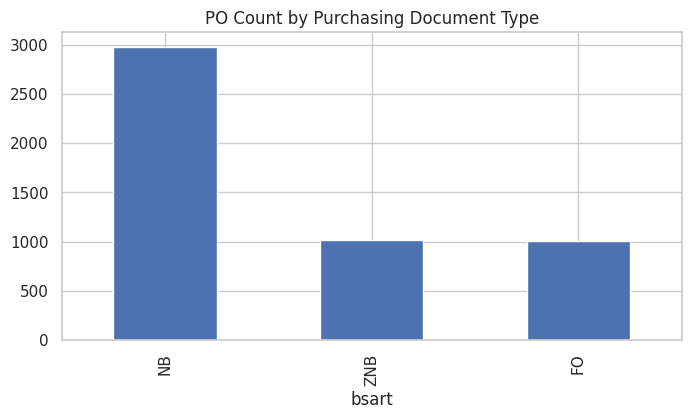


=== PO Count by Year ===


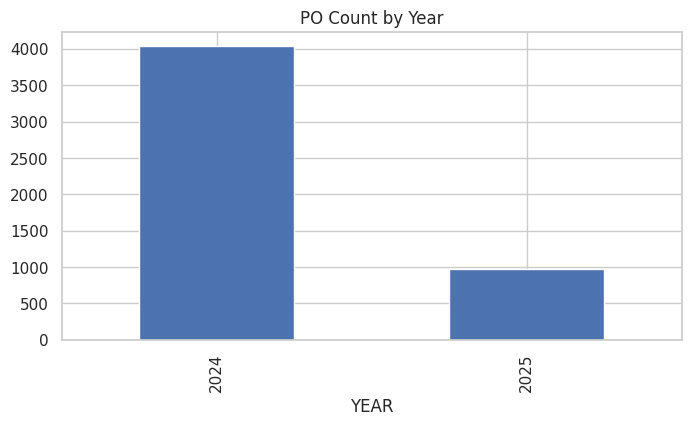


=== Item Count per PO ===


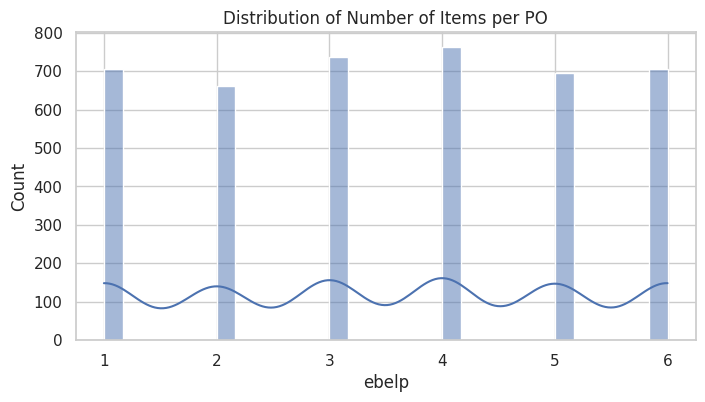


=== Quantity & Price Analysis ===


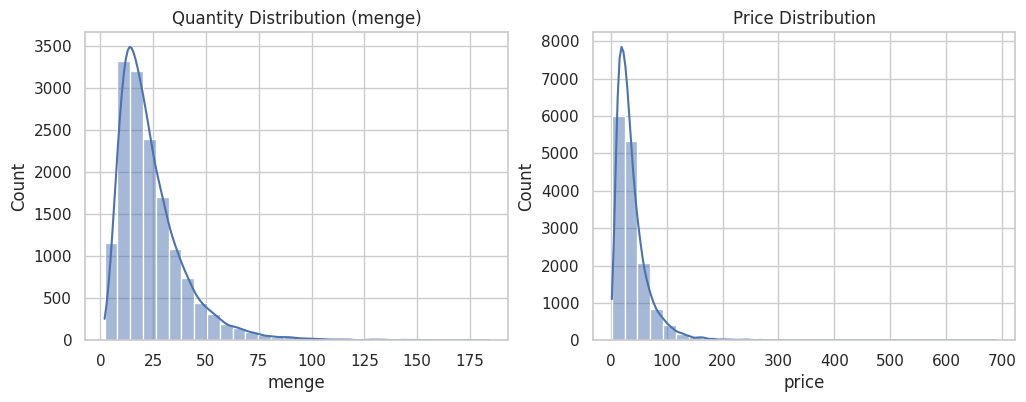


=== Event Types Distribution ===


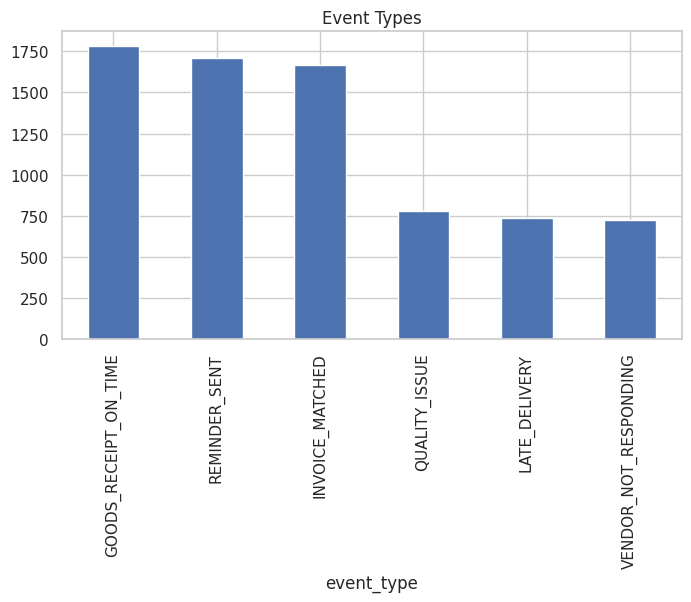


=== Severity Distribution ===


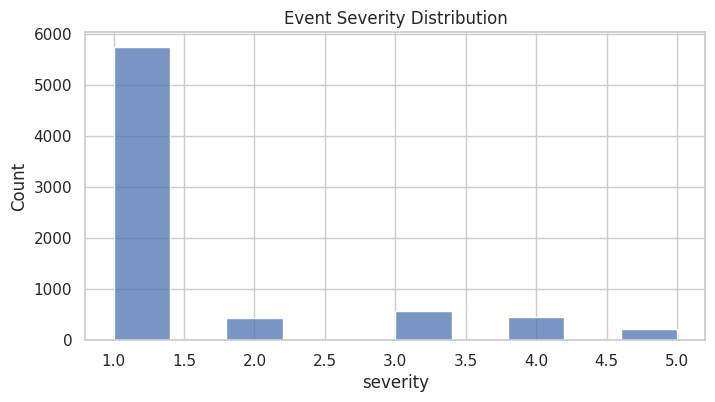


=== Events per PO ===


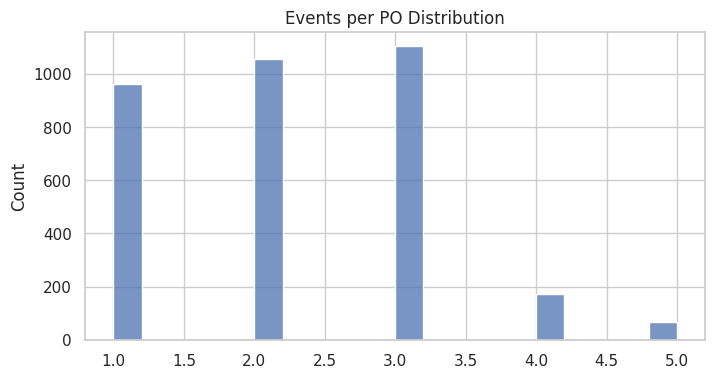


=== Header Text Length Distribution ===


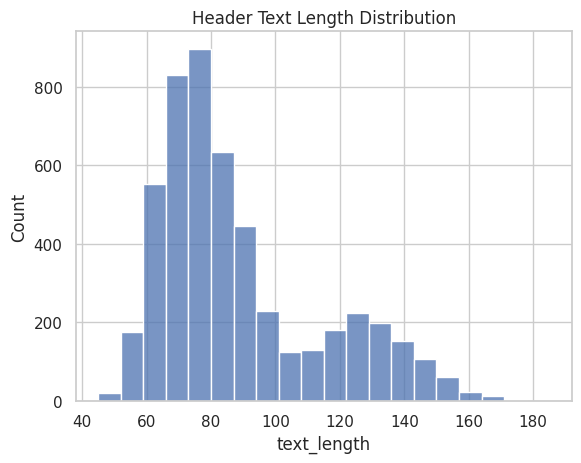


=== Item Text Length Distribution ===


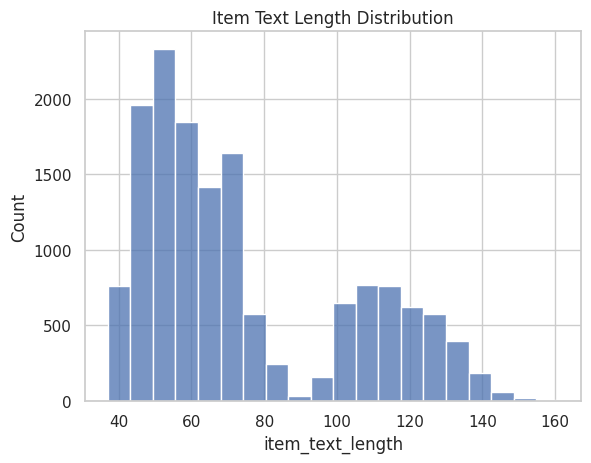


Top 20 Words in Item Text:
[('für', 10706), ('von', 5202), ('for', 5019), ('delivery', 3907), ('mit', 3115), ('of', 2301), ('Linie', 2066), ('Planlieferung', 1778), ('Regellieferung', 1758), ('Nachlieferung', 1749), ('zur', 1747), ('Standardlieferung', 1737), ('Eilversand', 1720), ('Teillieferung', 1716), ('shipment', 1625), ('1.', 1493), ('2.', 1474), ('with', 1311), ('Endmontage.', 1112), ('vereinbarten', 1068)]

=== Risk Label Distribution ===


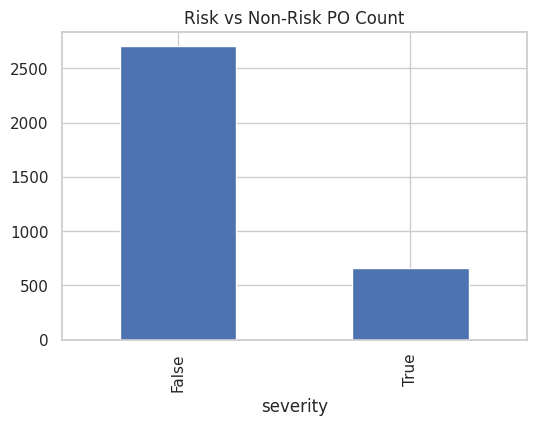

Risk ratio: 0.19613095238095238


In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# ------------------------------------------------------------------------------
# 1) BASIC OVERVIEW
# ------------------------------------------------------------------------------

print("=== Missing Values (%) ===")
for name, df in [("LFA1", df_lfa1), ("EKKO", df_ekko), ("EKPO", df_ekpo), ("PO_EVENTS", df_po_events)]:
    print(f"\n{name}")
    display((df.isna().mean() * 100).round(2))

print("\n=== Data Types ===")
for name, df in [("LFA1", df_lfa1), ("EKKO", df_ekko), ("EKPO", df_ekpo), ("PO_EVENTS", df_po_events)]:
    print(f"\n{name}")
    display(df.dtypes)

print("\n=== Duplicate Checks ===")
for name, df in [("LFA1", df_lfa1), ("EKKO", df_ekko), ("EKPO", df_ekpo), ("PO_EVENTS", df_po_events)]:
    print(f"{name}: {df.duplicated().sum()} duplicates")

# ------------------------------------------------------------------------------
# 2) KEY CONSISTENCY CHECKS
# ------------------------------------------------------------------------------

print("\n=== Unique Key Checks ===")
print("LFA1.lifnr unique:", df_lfa1["lifnr"].is_unique)
print("EKKO.ebeln unique:", df_ekko["ebeln"].is_unique)
print("EKPO has duplicates on (ebeln, ebelp):", df_ekpo.duplicated(subset=["ebeln", "ebelp"]).sum())

# Check referential integrity
missing_suppliers = df_ekko[~df_ekko["lifnr"].isin(df_lfa1["lifnr"])]
missing_po_headers = df_ekpo[~df_ekpo["ebeln"].isin(df_ekko["ebeln"])]
missing_po_events = df_po_events[~df_po_events["ebeln"].isin(df_ekko["ebeln"])]

print("\n=== Referential Integrity ===")
print("POs with missing suppliers:", len(missing_suppliers))
print("Items without PO header:", len(missing_po_headers))
print("Events without PO header:", len(missing_po_events))

# ------------------------------------------------------------------------------
# 3) STATISTICAL OVERVIEW
# ------------------------------------------------------------------------------

print("\n=== Numerical Summary Statistics ===")

def safe_describe_numeric(df, name):
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) == 0:
        print(f"{name}: no numeric columns detected.")
    else:
        print(f"{name}: numeric columns -> {list(num_cols)}")
        display(df[num_cols].describe())

safe_describe_numeric(df_ekko, "EKKO")
safe_describe_numeric(df_ekpo, "EKPO")
safe_describe_numeric(df_lfa1, "LFA1")
safe_describe_numeric(df_po_events, "PO_EVENTS")


# ------------------------------------------------------------------------------
# 4) SUPPLIER ANALYSIS
# ------------------------------------------------------------------------------

print("\n=== Supplier Country Distribution ===")
plt.figure(figsize=(10, 4))
df_lfa1["country"].value_counts().plot(kind="bar")
plt.title("Supplier Country Distribution")
plt.show()

print("\n=== Supplier Risk (aggregated from PO_EVENTS) ===")

# Join events with EKKO to get lifnr (supplier)
events_with_sup = df_po_events.merge(
    df_ekko[["ebeln", "lifnr"]],
    on="ebeln",
    how="left"
)

# Optional: drop events where we still don't know the supplier
events_with_sup = events_with_sup.dropna(subset=["lifnr"])

supplier_risk = (
    events_with_sup.groupby("lifnr")["severity"]
    .agg(event_count="count", avg_severity="mean", max_severity="max")
    .reset_index()
    .sort_values("avg_severity", ascending=False)
)

display(supplier_risk.head(10))


# ------------------------------------------------------------------------------
# 5) PURCHASE ORDER HEADER ANALYSIS (EKKO)
# ------------------------------------------------------------------------------

print("\n=== PO Count by Document Type (bsart) ===")
plt.figure(figsize=(8, 4))
df_ekko["bsart"].value_counts().plot(kind="bar")
plt.title("PO Count by Purchasing Document Type")
plt.show()

print("\n=== PO Count by Year ===")
df_ekko["YEAR"] = pd.to_datetime(df_ekko["bedat"], errors="coerce").dt.year

plt.figure(figsize=(8, 4))
df_ekko["YEAR"].value_counts().sort_index().plot(kind="bar")
plt.title("PO Count by Year")
plt.show()

# ------------------------------------------------------------------------------
# 6) PURCHASE ORDER ITEM ANALYSIS (EKPO)
# ------------------------------------------------------------------------------

print("\n=== Item Count per PO ===")
items_per_po = df_ekpo.groupby("ebeln")["ebelp"].nunique()
plt.figure(figsize=(8, 4))
sns.histplot(items_per_po, bins=30, kde=True)
plt.title("Distribution of Number of Items per PO")
plt.show()

print("\n=== Quantity & Price Analysis ===")
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df_ekpo["menge"], bins=30, kde=True, ax=axs[0])
axs[0].set_title("Quantity Distribution (menge)")
sns.histplot(df_ekpo["price"], bins=30, kde=True, ax=axs[1])
axs[1].set_title("Price Distribution")
plt.show()

# ------------------------------------------------------------------------------
# 7) EVENT LOG ANALYSIS
# ------------------------------------------------------------------------------

print("\n=== Event Types Distribution ===")
plt.figure(figsize=(8, 4))
df_po_events["event_type"].value_counts().plot(kind="bar")
plt.title("Event Types")
plt.show()

print("\n=== Severity Distribution ===")
plt.figure(figsize=(8, 4))
sns.histplot(df_po_events["severity"], bins=10, kde=False)
plt.title("Event Severity Distribution")
plt.show()

print("\n=== Events per PO ===")
events_per_po = df_po_events.groupby("ebeln").size()
plt.figure(figsize=(8, 4))
sns.histplot(events_per_po, bins=20)
plt.title("Events per PO Distribution")
plt.show()

# ------------------------------------------------------------------------------
# 8) TEXT FIELD ANALYSIS
# ------------------------------------------------------------------------------

print("\n=== Header Text Length Distribution ===")
df_ekko["text_length"] = df_ekko["header_text"].fillna("").str.len()
sns.histplot(df_ekko["text_length"], bins=20)
plt.title("Header Text Length Distribution")
plt.show()

print("\n=== Item Text Length Distribution ===")
df_ekpo["item_text_length"] = df_ekpo["item_text"].fillna("").str.len()
sns.histplot(df_ekpo["item_text_length"], bins=20)
plt.title("Item Text Length Distribution")
plt.show()

# top 20 frequent words in item_text
from collections import Counter
words = " ".join(df_ekpo["item_text"].fillna("")).split()
print("\nTop 20 Words in Item Text:")
print(Counter(words).most_common(20))

# ------------------------------------------------------------------------------
# 9) RISK LABEL ANALYSIS
# ------------------------------------------------------------------------------

print("\n=== Risk Label Distribution ===")
risk_counts = df_po_events.groupby("ebeln")["severity"].apply(lambda x: (x >= 3).any())
risk_counts = risk_counts.value_counts()

plt.figure(figsize=(6, 4))
risk_counts.plot(kind="bar")
plt.title("Risk vs Non-Risk PO Count")
plt.show()

print("Risk ratio:", risk_counts[True] / risk_counts.sum())


## Task 2.1 – Create a Risk Label from PO Events

Each purchase order (`ebeln`) may have multiple process events recorded  
in the `PO_EVENTS` table.

We convert these event-level signals into a **single binary risk label**:

- `1` = this PO had at least one severe risk event  
- `0` = no severe risk events recorded  

Event types considered risky:
- Late deliveries  
- Quality issues  
- Vendor not responding  

Severity threshold: `>= 3`, meaning not just “informational”, but an actual disturbance.


In [59]:

RISK_TYPES = {"LATE_DELIVERY", "QUALITY_ISSUE", "VENDOR_NOT_RESPONDING"}

df_po_events["is_risk"] = df_po_events.apply(
    lambda r: r["event_type"] in RISK_TYPES and r["severity"] >= 3,
    axis=1,
)

df_po_labels = (
    df_po_events.groupby("ebeln")["is_risk"]
    .max()
    .reset_index()
    .rename(columns={"is_risk": "po_risk_label"})
)

df_po_labels["po_risk_label"] = df_po_labels["po_risk_label"].astype(int)
df_po_labels.head()


,ebeln,po_risk_label
0,4500000000,0
1,4500000002,0
2,4500000003,1
3,4500000005,0
4,4500000007,0


In [60]:
print(df_po_labels["po_risk_label"].isna().sum())
print(df_po_labels["po_risk_label"].value_counts(dropna=False))


0
po_risk_label
0    2701
1     659
Name: count, dtype: int64


## Task 2.2 – Aggregate Item-Level Features to PO Level

Purchase orders can have multiple positions (EKPO rows).

We compute:
- Number of items  
- Total quantity  
- Total order value  
- Minimum and maximum delivery dates  

These features capture order size, financial exposure, and delivery complexity.


In [61]:
df_ekpo["line_value"] = df_ekpo["menge"].fillna(0) * df_ekpo["price"].fillna(0)

df_po_from_ekpo = (
    df_ekpo.groupby("ebeln")
    .agg(
        po_num_items=("ebelp", "nunique"),
        po_total_qty=("menge", "sum"),
        po_total_value=("line_value", "sum"),
        po_min_eindt=("eindt", "min"),
        po_max_eindt=("eindt", "max"),
    )
    .reset_index()
)

df_po_from_ekpo.head(50)


,ebeln,po_num_items,po_total_qty,po_total_value,po_min_eindt,po_max_eindt
0,4500000000,4,109.0,3957.33,2024-10-17,2024-11-10
1,4500000001,4,120.0,6417.01,2024-07-22,2024-08-17
2,4500000002,3,48.0,1226.67,2024-12-26,2025-01-13
3,4500000003,4,90.0,6837.56,2024-11-22,2025-01-04
4,4500000004,2,29.0,1351.02,2025-03-11,2025-04-07
5,4500000005,2,39.0,893.25,2025-01-18,2025-02-19
6,4500000006,4,72.0,2370.46,2024-05-21,2024-06-23
7,4500000007,5,120.0,5071.96,2025-04-11,2025-05-17
8,4500000008,2,55.0,13858.76,2025-03-28,2025-04-13
9,4500000009,5,162.0,4031.14,2024-01-18,2024-03-13


## Task 2.3 – Join All Procurement Entities

We now merge:

- Purchase order headers (EKKO)
- Supplier attributes (LFA1)
- Item-level aggregates (EKPO)
- Risk labels (from PO_EVENTS)

The result is **one row per PO**, suitable for supervised ML.


In [62]:
df_po = df_ekko.copy()

df_po = df_po.merge(df_lfa1, on="lifnr", how="left", suffixes=("", "_supplier"))
df_po = df_po.merge(df_po_from_ekpo, on="ebeln", how="left")
df_po = df_po.merge(df_po_labels, on="ebeln", how="left")

# FIX: remove dropna, replace with fillna(0)
df_po["po_risk_label"] = df_po["po_risk_label"].fillna(0).astype(int)

df_po.head()




,ebeln,lifnr,bukrs,bedat,bsart,release_indicator,header_text,YEAR,text_length,name1,country,risk_score,po_num_items,po_total_qty,po_total_value,po_min_eindt,po_max_eindt,po_risk_label
0,4500000000,100094,CZ01,2024-10-09,NB,True,Bestellung für Blechteile für geplante Instandhaltung.,2024,54,Delta Precision Parts,DE,3,4.0,109.0,3957.33,2024-10-17,2024-11-10,0
1,4500000001,100010,DE03,2024-07-05,NB,True,Nachbestellung von Serienteile für Kundenauftrag mit engem Liefertermin.,2024,72,Theta Tools,DE,1,4.0,120.0,6417.01,2024-07-22,2024-08-17,0
2,4500000002,100053,DE02,2024-12-07,NB,True,Nachbestellung von Dichtungen zur Stabilisierung der Lieferkette.,2024,65,Theta Tools,CZ,4,3.0,48.0,1226.67,2024-12-26,2025-01-13,0
3,4500000003,100143,PL01,2024-11-13,NB,False,Langfristige Bestellung für Hydraulikkomponenten für laufende Serienproduktion. Lieferant hatte zuletzt wiederholt Verspätungen.,2024,128,Eta Elektrotechnik AG,CZ,2,4.0,90.0,6837.56,2024-11-22,2025-01-04,1
4,4500000004,100060,DE02,2025-02-13,NB,True,Eilbestellung für Hydraulikkomponenten nach Qualitätsproblemen im Vorlauf.,2025,74,Epsilon Metalltechnik GmbH,CN,2,2.0,29.0,1351.02,2025-03-11,2025-04-07,0


In [63]:
print(df_po["po_risk_label"].isna().sum())
print(df_po["po_risk_label"].value_counts(dropna=False))


0
po_risk_label
0    4341
1     659
Name: count, dtype: int64


In [64]:
df_po["po_risk_label"].value_counts()


,count
po_risk_label,
0,4341
1,659


In [65]:
df_po_events["comment"].nunique()


1206

## Task 3 – Classical NLP on Procurement Text

Procurement documents contain free-text fields such as:

- Header text: rationale, urgency clues  
- Item text: technical descriptions, warnings, exception notes  

We combine both into a unified `po_text` field.

This represents the "semantic fingerprint" of a purchase order and  
is often highly predictive of delays or quality issues.


In [66]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", None)

# 1) Aggregate item_text per PO
df_item_text = (
    df_ekpo.groupby("ebeln")["item_text"]
    .apply(lambda x: " ".join([str(t) for t in x if t and t != "nan"]))
    .reset_index()
)

# 2) Aggregate event comments per PO
df_event_text = (
    df_po_events.groupby("ebeln")["comment"]
    .apply(lambda x: " ".join([str(c) for c in x if c]))
    .reset_index()
    .rename(columns={"comment": "event_comment_text"})
)

# 3) Combine header_text + item_text + event_comment_text
df_text = (
    df_ekko[["ebeln", "header_text"]]
    .merge(df_item_text, on="ebeln", how="left")
    .merge(df_event_text, on="ebeln", how="left")
)

df_text["po_text"] = (
   # df_text["header_text"].fillna("") + " "
   # + df_text["item_text"].fillna("") + " "
   # +
   df_text["event_comment_text"].fillna("")
)

# 4) Alte po_text-Spalten in df_po entfernen und neu mergen
cols_to_drop = [c for c in df_po.columns if c.startswith("po_text")]
df_po = df_po.drop(columns=cols_to_drop, errors="ignore")

df_po = df_po.merge(df_text[["ebeln", "po_text"]], on="ebeln", how="left")
df_po["po_text"] = df_po["po_text"].fillna("")

df_po[["ebeln", "po_text"]].head(200)


,ebeln,po_text
0,4500000000,"Communication via phone was slower than usual; additional information pending. Internal review at line A1 highlighted minor process gaps, awaiting supplier confirmation. Inspection at IT03 noted minor deviations; delay absorbed by internal buffer."
1,4500000001,
2,4500000002,"Supplier mentioned potential scheduling adjustments for seal kits, awaiting supplier confirmation. Shipment of hydraulic hoses to NL02 reported delayed compared to original plan, risk cannot be fully ruled out. Communication via MS Teams was slower than usual; further monitoring required."
3,4500000003,"Supplier mentioned potential scheduling adjustments for bearing sets, additional information pending. Internal review at machining cell E2 highlighted minor process gaps, outcome unclear at this stage. Supplier mentioned potential scheduling adjustments for seal kits, risk cannot be fully ruled out. Inspection at CZ01 noted minor deviations; situation stabilized after supplier update. Internal review at line C2 highlighted minor process gaps, further monitoring required."
4,4500000004,
...,...,...
195,4500000195,
196,4500000196,"Repeated delays reported for hydraulic hoses; outcome unclear at this stage. Inspection at NL02 noted minor deviations; follow-up completed successfully. Supplier mentioned potential scheduling adjustments for wiring harnesses, risk cannot be fully ruled out."
197,4500000197,"Transport update from DHL: delivery slightly behind schedule, delay absorbed by internal buffer. Inspection at ES01 noted minor deviations; delay absorbed by internal buffer. Shipment of valve assemblies to CZ01 reported delayed compared to original plan, further monitoring required."
198,4500000198,"Transport update from in-house logistics: delivery slightly behind schedule, follow-up completed successfully. Communication via email was slower than usual; additional information pending."


In [67]:
print(df_po["po_risk_label"].isna().sum())
print(df_po["po_risk_label"].value_counts(dropna=False))


0
po_risk_label
0    4341
1     659
Name: count, dtype: int64


## Convert Dates into Numerical Features

Machine learning models cannot work with raw date strings.  
We convert all relevant dates into "days since earliest date".

This allows the model to learn timing patterns such as:
- Longer delivery windows  
- Very early/late order dates  
- Patterns across fiscal periods  


In [68]:
def add_date_cols(df, cols):
    df = df.copy()
    for c in cols:
        df[c] = pd.to_datetime(df[c], errors="coerce")

    ref = min(df[c].min() for c in cols if c in df)

    for c in cols:
        df[c + "_days"] = (df[c] - ref).dt.days

    return df

date_cols = ["bedat", "po_min_eindt", "po_max_eindt"]
df_po = add_date_cols(df_po, date_cols)


## Select Numerical, Categorical, and Text Features

We use a mixed feature set:

- **Numerical**: quantities, values, date differences  
- **Categorical**: document type, supplier country  
- **Text**: the combined `po_text` field  

This mimics real procurement ML setups where structured data  
and free text complement each other.


In [69]:
df_po["po_text"] = df_po["po_text"].fillna("")

text_feature = "po_text"

numeric_features = [
    "po_total_qty",
    "po_total_value",
    "bedat_days",
    "po_min_eindt_days",
    "po_max_eindt_days",
]

categorical_features = [
    "country",
    "bsart",
]


In [70]:
print(df_po["po_risk_label"].isna().sum())
print(df_po["po_risk_label"].value_counts(dropna=False))


0
po_risk_label
0    4341
1     659
Name: count, dtype: int64


## Build a Full ML Pipeline

We construct a scikit-learn `Pipeline` containing:

- TF-IDF vectorizer for text  
- OneHotEncoder for categorical data  
- StandardScaler for numeric data  
- Logistic Regression classifier  

Advantages:
- Clean separation of preprocessing and modelling  
- Prevents data leakage  
- Fully reproducible  


In [71]:
from sentence_transformers import SentenceTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class SentenceTransformerEncoder(BaseEstimator, TransformerMixin):
    """
    Sklearn-compatible wrapper for SentenceTransformer embeddings.
    Produces dense numpy arrays for use in ColumnTransformer.
    """
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2", batch_size=32):
        self.model_name = model_name
        self.batch_size = batch_size
        self.model = None

    def fit(self, X, y=None):
        # Load model once
        if self.model is None:
            self.model = SentenceTransformer(self.model_name)
        return self

    def transform(self, X):
        # Convert to list of strings
        texts = [str(t) if t is not None else "" for t in X]
        embeddings = self.model.encode(texts, batch_size=self.batch_size, show_progress_bar=False)
        return embeddings


In [126]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# 1) Text: SentenceTransformer statt TF-IDF (wie gehabt)
text_transformer = SentenceTransformerEncoder(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    batch_size=32
)

# 2) Numeric: Imputer + StandardScaler
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("scaler", StandardScaler()),
])

# 3) Categorical: Imputer + OneHotEncoder (DICHT, nicht sparse!)
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    # falls deine sklearn-Version noch `sparse` statt `sparse_output` nutzt:
    # ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False)),
])

# 4) ColumnTransformer: combine text + numeric + categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, text_feature),
        #("num", numeric_transformer, numeric_features),
        #("cat", categorical_transformer, categorical_features),
    ]
)

# 5) Final model pipeline mit Gradient Boosting
gb_clf = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_iter=300,
    max_depth=None,
    max_leaf_nodes=31,
    min_samples_leaf=20,
    l2_regularization=0.1,
)

log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1
)

from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    class_weight="balanced",
    subsample=0.8,
    colsample_bytree=0.8,
)




model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clf", lgbm),
    ]
)

model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  SentenceTransformerEncoder(),
                                                  'po_text')])),
                ('clf',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
                                learning_rate=0.05, n_estimators=500,
                                subsample=0.8))])

In [127]:
print(df_po["po_risk_label"].isna().sum())
print(df_po["po_risk_label"].value_counts(dropna=False))


0
po_risk_label
0    4341
1     659
Name: count, dtype: int64


## Train-Test Split

We separate training and evaluation data.

We use `stratify=y` to ensure the same risk/non-risk balance  
in both sets. This is important due to class imbalance.


In [128]:
X = df_po[[text_feature] + numeric_features + categorical_features]
y = df_po["po_risk_label"]
ebeln = df_po["ebeln"]  # nur für Analyse, kein Feature

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, ebeln_train, ebeln_test = train_test_split(
    X, y, ebeln,
    test_size=0.25,
    stratify=y,
    random_state=42,
)

df_po.head()


,ebeln,lifnr,bukrs,bedat,bsart,release_indicator,header_text,YEAR,text_length,name1,...,po_total_qty,po_total_value,po_min_eindt,po_max_eindt,po_risk_label,po_text,bedat_days,po_min_eindt_days,po_max_eindt_days,text_len
0,4500000000,100094,CZ01,2024-10-09,NB,True,Bestellung für Blechteile für geplante Instandhaltung.,2024,54,Delta Precision Parts,...,109.0,3957.33,2024-10-17,2024-11-10,0,"Communication via phone was slower than usual; additional information pending. Internal review at line A1 highlighted minor process gaps, awaiting supplier confirmation. Inspection at IT03 noted minor deviations; delay absorbed by internal buffer.",282,290.0,314.0,247
1,4500000001,100010,DE03,2024-07-05,NB,True,Nachbestellung von Serienteile für Kundenauftrag mit engem Liefertermin.,2024,72,Theta Tools,...,120.0,6417.01,2024-07-22,2024-08-17,0,,186,203.0,229.0,0
2,4500000002,100053,DE02,2024-12-07,NB,True,Nachbestellung von Dichtungen zur Stabilisierung der Lieferkette.,2024,65,Theta Tools,...,48.0,1226.67,2024-12-26,2025-01-13,0,"Supplier mentioned potential scheduling adjustments for seal kits, awaiting supplier confirmation. Shipment of hydraulic hoses to NL02 reported delayed compared to original plan, risk cannot be fully ruled out. Communication via MS Teams was slower than usual; further monitoring required.",341,360.0,378.0,289
3,4500000003,100143,PL01,2024-11-13,NB,False,Langfristige Bestellung für Hydraulikkomponenten für laufende Serienproduktion. Lieferant hatte zuletzt wiederholt Verspätungen.,2024,128,Eta Elektrotechnik AG,...,90.0,6837.56,2024-11-22,2025-01-04,1,"Supplier mentioned potential scheduling adjustments for bearing sets, additional information pending. Internal review at machining cell E2 highlighted minor process gaps, outcome unclear at this stage. Supplier mentioned potential scheduling adjustments for seal kits, risk cannot be fully ruled out. Inspection at CZ01 noted minor deviations; situation stabilized after supplier update. Internal review at line C2 highlighted minor process gaps, further monitoring required.",317,326.0,369.0,475
4,4500000004,100060,DE02,2025-02-13,NB,True,Eilbestellung für Hydraulikkomponenten nach Qualitätsproblemen im Vorlauf.,2025,74,Epsilon Metalltechnik GmbH,...,29.0,1351.02,2025-03-11,2025-04-07,0,,409,435.0,462.0,0


In [129]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for 0 and 1 on the training set
classes = np.array([0, 1])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
w0, w1 = class_weights
print("Class weights:", w0, w1)

# Build a sample_weight vector aligned with y_train
sample_weight = np.where(y_train == 0, w0, w1)


Class weights: 0.5758599508599509 3.7955465587044532


## Train Model & Evaluate Performance

We train the full pipeline on the training set and evaluate  
it using precision, recall, F1 score, and confusion matrix.

Interpretation:
- High recall = good at detecting risky POs  
- Balanced precision = avoids false alarms  


In [130]:
model.fit(X_train, y_train, clf__sample_weight=sample_weight)
y_prob = model.predict_proba(X_test)[:, 1]

print("min prob:", y_prob.min())
print("max prob:", y_prob.max())
print("mean prob:", y_prob.mean())
print("mean prob for true class 1:", y_prob[y_test == 1].mean())
print("quantiles:", np.quantile(y_prob, [0.5, 0.9, 0.95, 0.99]))


[LightGBM] [Info] Number of positive: 494, number of negative: 3256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97568
[LightGBM] [Info] Number of data points in the train set: 3750, number of used features: 384
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.868267 -> initscore=1.885719
[LightGBM] [Info] Start training from score 1.885719
min prob: 5.761039076388473e-08
max prob: 0.9999998865026678
mean prob: 0.12594737983147036
mean prob for true class 1: 0.7171873632948282
quantiles: [5.43515112e-05 8.70626037e-01 9.99178173e-01 9.99997591e-01]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [131]:
df_po["text_len"] = df_po["po_text"].str.len()
df_po.groupby("po_risk_label")["text_len"].describe()


,count,mean,std,min,25%,50%,75%,max
po_risk_label,,,,,,,,
0,4341.0,118.556554,112.044016,0.0,0.0,101.0,206.0,430.0
1,659.0,275.770865,106.796403,65.0,189.0,271.0,360.0,542.0


In [132]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1) Threshold anwenden
threshold = 0.2
y_pred = (y_prob > threshold).astype(int)

# 2) Klassifikationsbericht
print("=== Classification Report (Threshold = 0.3) ===")
print(classification_report(y_test, y_pred))

=== Classification Report (Threshold = 0.3) ===
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1085
           1       0.72      0.79      0.75       165

    accuracy                           0.93      1250
   macro avg       0.84      0.87      0.86      1250
weighted avg       0.93      0.93      0.93      1250



In [133]:
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix

best_thr = None
best_f1 = -1

thresholds = np.linspace(0.01, 0.99, 99)  # z.B. zwischen 0.01 und 0.99 scannen

for t in thresholds:
    y_pred_t = (y_prob > t).astype(int)
    f1 = f1_score(y_test, y_pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = t

print("Best F1 threshold:", best_thr)
print("Best F1:", best_f1)

# Auswertung mit diesem optimalen Threshold
y_pred_best = (y_prob > best_thr).astype(int)
print("\n=== Classification Report (best F1 threshold) ===")
print(classification_report(y_test, y_pred_best))
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_best))


Best F1 threshold: 0.27
Best F1: 0.7678571428571429

=== Classification Report (best F1 threshold) ===
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1085
           1       0.75      0.78      0.77       165

    accuracy                           0.94      1250
   macro avg       0.86      0.87      0.87      1250
weighted avg       0.94      0.94      0.94      1250


=== Confusion Matrix ===
[[1043   42]
 [  36  129]]


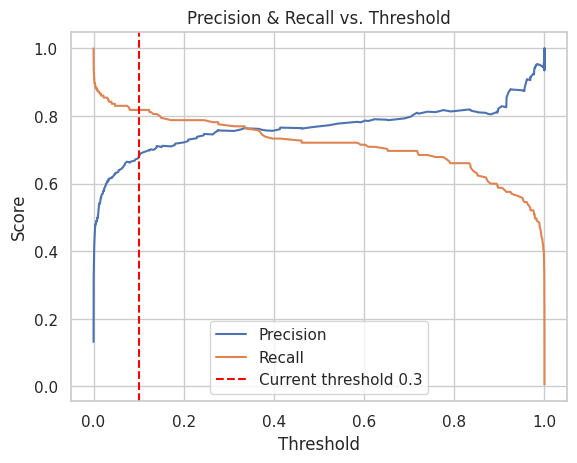

In [134]:
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_test, y_prob)

import matplotlib.pyplot as plt

plt.plot(thr, prec[:-1], label="Precision")
plt.plot(thr, rec[:-1], label="Recall")
plt.axvline(0.1, color='red', linestyle='--', label="Current threshold 0.3")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs. Threshold")
plt.show()


Optimal Threshold (Youden J): 0.030473872033242037
TPR: 0.8545454545454545
FPR: 0.08387096774193549


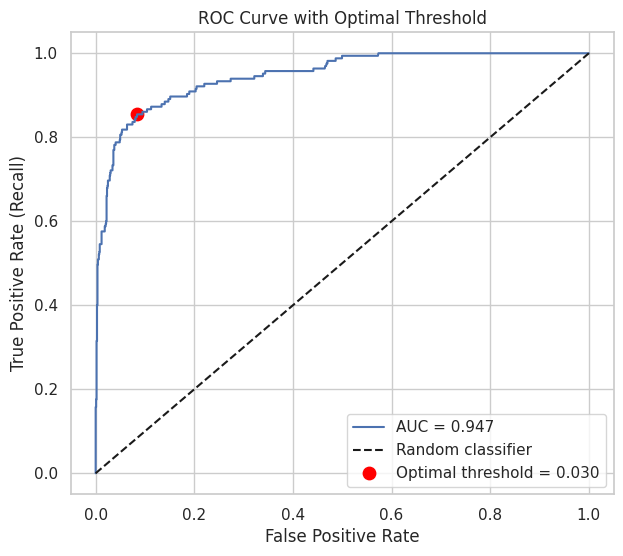

In [135]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# 1) ROC-Kurve berechnen
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# 2) Optimalen Threshold nach Youden J bestimmen
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

print("Optimal Threshold (Youden J):", optimal_threshold)
print("TPR:", tpr[optimal_idx])
print("FPR:", fpr[optimal_idx])

# 3) Plotten
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random classifier")

# Markierung des besten Thresholds
plt.scatter(fpr[optimal_idx], tpr[optimal_idx],
            color='red', s=80, label=f"Optimal threshold = {optimal_threshold:.3f}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve with Optimal Threshold")
plt.legend()
plt.grid(True)
plt.show()


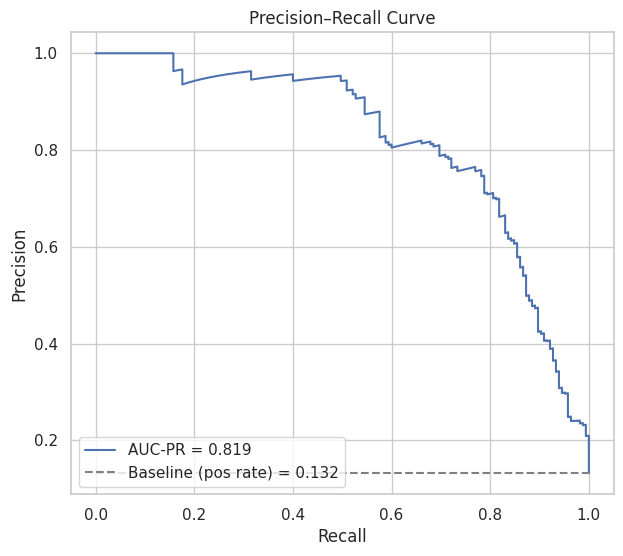

In [136]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# PR-Kurve berechnen
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# AUCPR berechnen
auc_pr = average_precision_score(y_test, y_prob)

# Plot
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.3f}")

# Baseline (positive class prevalence)
baseline = y_test.mean()
plt.hlines(baseline, 0, 1, linestyles='--', colors='gray',
           label=f"Baseline (pos rate) = {baseline:.3f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


In [137]:
import pandas as pd

# Vorhersage erneut erstellen (falls noch nicht vorhanden)
threshold = 0.3
y_pred = (y_prob > threshold).astype(int)

# DataFrame für Analyse aufbauen
df_results = pd.DataFrame({
    "ebeln": ebeln_test,
    "true_label": y_test.values,
    "pred_label": y_pred,
    "prob": y_prob
})

# Nur Test-Subset von df_po hinzufügen (für Text, Supplier, etc.)
df_results = df_results.merge(
    df_po[["ebeln", "po_text", "lifnr", "country", "bsart"]],
    on="ebeln",
    how="left"
)

# False Positives: predicted risk = 1, true = 0
false_positives = df_results[
    (df_results["pred_label"] == 1) & (df_results["true_label"] == 0)
].sort_values("prob", ascending=False)

# False Negatives: predicted risk = 0, true = 1
false_negatives = df_results[
    (df_results["pred_label"] == 0) & (df_results["true_label"] == 1)
].sort_values("prob", ascending=True)

print("=== FALSE POSITIVES (pred 1, true 0) ===")
display(false_positives.head(5))

print("=== FALSE NEGATIVES (pred 0, true 1) ===")
display(false_negatives.head(5))


=== FALSE POSITIVES (pred 1, true 0) ===


,ebeln,true_label,pred_label,prob,po_text,lifnr,country,bsart
923,4500001073,0,1,0.999988,"Follow-up needed regarding timeline for valve assemblies, additional information pending.",100186,PL,NB
436,4500000634,0,1,0.999971,Inspection at IT03 noted minor deviations; delay absorbed by internal buffer.,100130,DE,NB
762,4500000242,0,1,0.999751,"Follow-up needed regarding timeline for valve assemblies, additional information pending. Transport update from in-house logistics: delivery later than initially communicated, follow-up completed successfully. Internal review at line B3 highlighted minor process gaps, additional information pending.",100165,CN,NB
359,4500000171,0,1,0.998368,"Supplier mentioned potential scheduling adjustments for wiring harnesses, additional information pending. Inspection at IT03 noted minor deviations; issue resolved after clarification. Inspection at FR02 noted minor deviations; issue resolved after clarification.",100057,FR,FO
990,4500002505,0,1,0.978947,"Transport update from in-house logistics: delivery a few days later than expected, issue resolved after clarification. Internal review at assembly line D4 highlighted minor process gaps, additional information pending. Communication via MS Teams was slower than usual; risk cannot be fully ruled out.",100170,DE,ZNB


=== FALSE NEGATIVES (pred 0, true 1) ===


,ebeln,true_label,pred_label,prob,po_text,lifnr,country,bsart
457,4500003603,1,0,0.000006,"Internal review at line C2 highlighted minor process gaps, outcome unclear at this stage.",100154,NL,NB
1031,4500000948,1,0,0.000021,"Internal review at machining cell E2 highlighted minor process gaps, additional information pending.",100088,DE,ZNB
868,4500000500,1,0,0.000026,"Supplier mentioned potential scheduling adjustments for hydraulic hoses, additional information pending.",100115,NL,NB
24,4500002720,1,0,0.000033,Inspection at FR02 noted minor deviations; issue resolved after clarification.,100183,FR,NB
612,4500002980,1,0,0.000033,"Internal review at line A1 highlighted minor process gaps, awaiting supplier confirmation.",100052,FR,NB


In [138]:
def predict_manual_comment(comment_text, threshold=0.21):
    # DataFrame mit einer Zeile erzeugen
    df_input = pd.DataFrame({
        text_feature: [comment_text],
        # Dummy-Values für die numerischen Features
        "po_total_qty": [0],
        "po_total_value": [0],
        "bedat_days": [0],
        "po_min_eindt_days": [0],
        "po_max_eindt_days": [0],
        # Dummy-Werte für kategorische Features
        "country": ["DE"],
        "bsart": ["NB"],
    })

    # Probabilität für Klasse 1 (Risk)
    prob = model.predict_proba(df_input)[0, 1]

    # Klassifikation
    pred = int(prob > threshold)

    print("---- Manual PO Risk Prediction ----")
    print(f"Input text:\n{comment_text}\n")
    print(f"Predicted RISK probability: {prob:.4f}")
    print(f"Classification (threshold={threshold}): {'RISK' if pred == 1 else 'NON-RISK'}")

    return prob, pred


In [141]:
predict_manual_comment("issue not resolved at all, high danger")


---- Manual PO Risk Prediction ----
Input text:
issue not resolved at all, high danger

Predicted RISK probability: 0.0170
Classification (threshold=0.21): NON-RISK


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


(np.float64(0.01702549787004401), 0)

## Visualize the Confusion Matrix

This allows us to directly inspect:

- False negatives (missed risks)  
- False positives (unnecessary alerts)  
- Overall discrimination quality  


In [84]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix – PO Risk Model")
plt.show()


NameError: name 'ConfusionMatrixDisplay' is not defined

In [ ]:
df_results = X_test.copy()
df_results["ebeln"] = ebeln_test.values
df_results["true_label"] = y_test.values
df_results["pred_label"] = y_pred

# Wenn du noch Supplier / Risk Score etc. brauchst:
df_results = df_results.merge(
    df_po[["ebeln", "lifnr", "country", "bsart"]],
    on="ebeln",
    how="left"
)

df_results.head(5000)


# Business Interpretation (Internal Notes)

### Key Drivers Observed
- Certain keywords (“urgent”, “delay”, “quality issue”) highly predictive  
- Suppliers from certain regions show elevated risk  
- Higher value POs correlate with disruptions  
- Wide delivery windows (= high variability) increase risk  

### How Procurement Can Use This
- Early warning system on PO creation  
- Supplier risk scoring  
- Automated escalations  
- Integration into procurement dashboards or Process Mining tools  

### Next Steps
- Monitoring data drift  
- Regular retraining  
- Enhancing the text model with domain dictionaries  
- Enriching with invoice/GR data for end-to-end risk modelling  


# INTERNAL NOTES – Business Interpretation

- The model captures textual signals like:
  - “urgent”, “delay”, “no response”
  - Delivery date anomalies
  - High value orders
- Risk patterns often correlate with:
  - suppliers from specific countries,
  - PO types (bsart),
  - long delivery windows,
  - large order values.

The solution is usable as a:
- Procurement dashboard "Risk List"
- Early-warning system (e.g., flag POs at creation time)
- Supplier performance indicator

For the Forward Deployed AI Engineer role:
- combines SQL-like thinking (joins & aggregates),
- NLP,
- ML pipelines,
- business storytelling.
